#Import Libraries


In [2]:
import io
import requests
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.image as mpimg
from pathlib import Path

# Download Images

In [3]:
zip_url = 'https://archive.ics.uci.edu/static/public/389/devanagari+handwritten+character+dataset.zip'

response = requests.get(zip_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    print(zf.namelist())
    zf.extractall('/content/extracted')

zf.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
!nvidia-smi

Tue Dec 12 02:56:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Visualize raw images

Class: Test
  Subfolder: character_27_ra


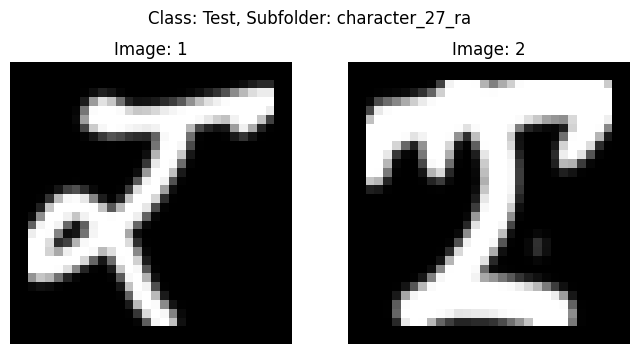

  Subfolder: character_22_pha


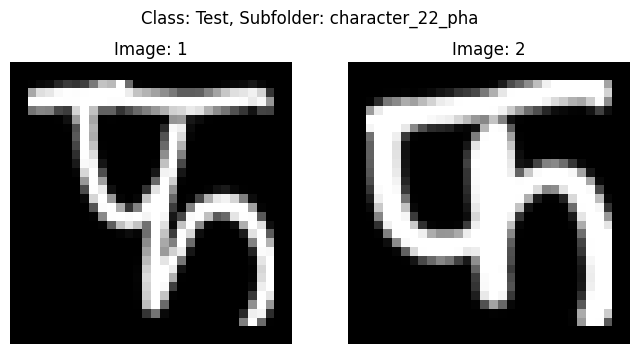

Class: Train
  Subfolder: character_27_ra


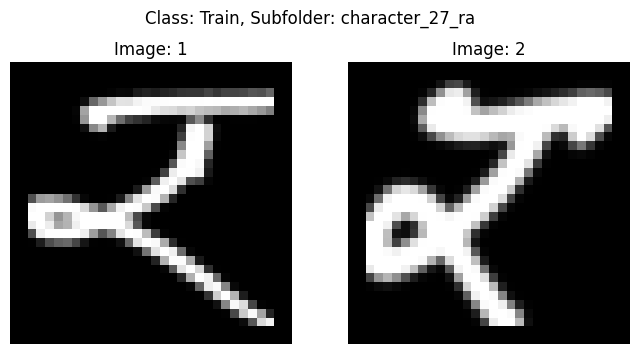

  Subfolder: character_22_pha


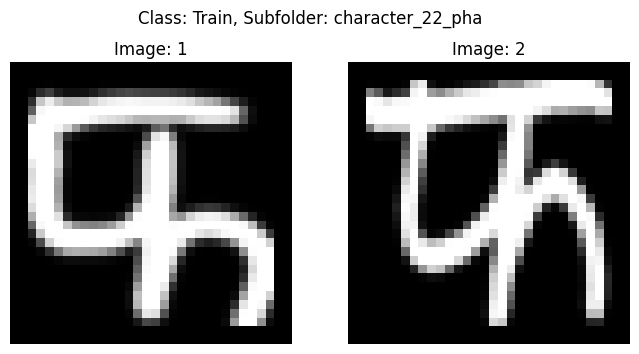

In [5]:
def display_images(class_folder, img_folder, num_images=2):
    img_folder_path = Path(dataset_folder) / class_folder / img_folder
    images = list(img_folder_path.glob('*'))[:num_images]

    plt.figure(figsize=(8, 4))  # Adjust the figure size as needed

    for i, img_path in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {i + 1}")
        plt.axis('off')

    plt.suptitle(f"Class: {class_folder}, Subfolder: {img_folder}")
    plt.show()

dataset_folder = '/content/extracted/DevanagariHandwrittenCharacterDataset'

# Iterate through the first three subfolders
for class_folder in os.listdir(dataset_folder)[:3]:
    print(f"Class: {class_folder}")

    # Display images for each sub-subfolder
    for img_folder_name in os.listdir(Path(dataset_folder) / class_folder)[:2]:
        print(f"  Subfolder: {img_folder_name}")

        # Display the images in the same line
        display_images(class_folder, img_folder_name)


# Load images into Data Loaders

In [6]:
# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
data_dir = '/content/extracted/DevanagariHandwrittenCharacterDataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=64,
                                              shuffle=True,
                                              num_workers=4,
                                              pin_memory=True)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# View Training Images

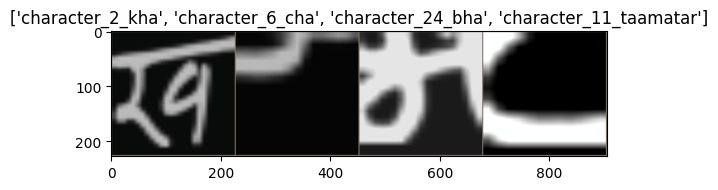

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = image_datasets['Train'].classes

# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Select the first four images from the batch
subset_inputs = inputs[:4]
subset_classes = classes[:4]

# Make a grid from the subset
out = torchvision.utils.make_grid(subset_inputs)

imshow(out, title=[class_names[x] for x in subset_classes])

# Define Model and Optimizer

In [8]:
# Use a pre-trained ResNet-101 model
model = models.resnet101(pretrained=True)

# Finetune
for param in model.parameters():
    param.requires_grad = True

# Modify the last fully connected layer for the number of classes in your dataset
num_classes = len(image_datasets['Train'].classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU
model = model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.2MB/s]


# Train Loop - Let the training begin!

In [9]:
# Initialize empty lists to store loss values
train_loss_values = []
test_loss_values = []

# Initialize empty lists to store accuracy values
train_acc_values = []
test_acc_values = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print()
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['Train', 'Test']:
        if phase == 'Train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate loss and accuracy for the epoch
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'Train':
            train_loss_values.append(epoch_loss)
            train_acc_values.append(epoch_acc)
            exp_lr_scheduler.step()
        else:
            test_loss_values.append(epoch_loss)
            test_acc_values.append(epoch_acc)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")



Epoch 0/4
----------
Train Epoch 0/5 Loss: 1.6330 Acc: 0.5854
Test Epoch 0/5 Loss: 0.1175 Acc: 0.9710

Epoch 1/4
----------
Train Epoch 1/5 Loss: 0.7943 Acc: 0.7756
Test Epoch 1/5 Loss: 0.0609 Acc: 0.9855

Epoch 2/4
----------
Train Epoch 2/5 Loss: 0.6830 Acc: 0.8009
Test Epoch 2/5 Loss: 0.0429 Acc: 0.9898

Epoch 3/4
----------
Train Epoch 3/5 Loss: 0.6286 Acc: 0.8166
Test Epoch 3/5 Loss: 0.0359 Acc: 0.9906

Epoch 4/4
----------
Train Epoch 4/5 Loss: 0.5904 Acc: 0.8265
Test Epoch 4/5 Loss: 0.0308 Acc: 0.9922
Training complete!


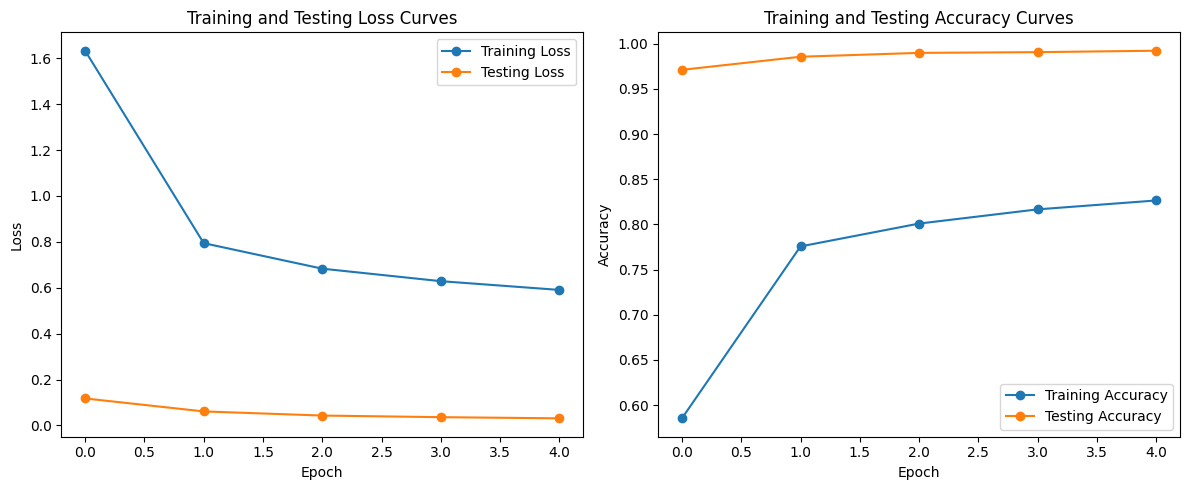

In [16]:
# Plot the loss curves
plt.figure(figsize=(12, 5))

# Plot training and testing loss on the same graph
plt.subplot(1, 2, 1)

train_acc_values_cpu = [acc.cpu().numpy() for acc in train_acc_values]
test_acc_values_cpu = [acc.cpu().numpy() for acc in test_acc_values]

plt.plot(train_loss_values, label='Training Loss', marker='o')
plt.plot(test_loss_values, label='Testing Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 2)

# Plot training and testing accuracy on the same graph
plt.plot(train_acc_values_cpu, label='Training Accuracy', marker='o')
plt.plot(test_acc_values_cpu, label='Testing Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize Model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


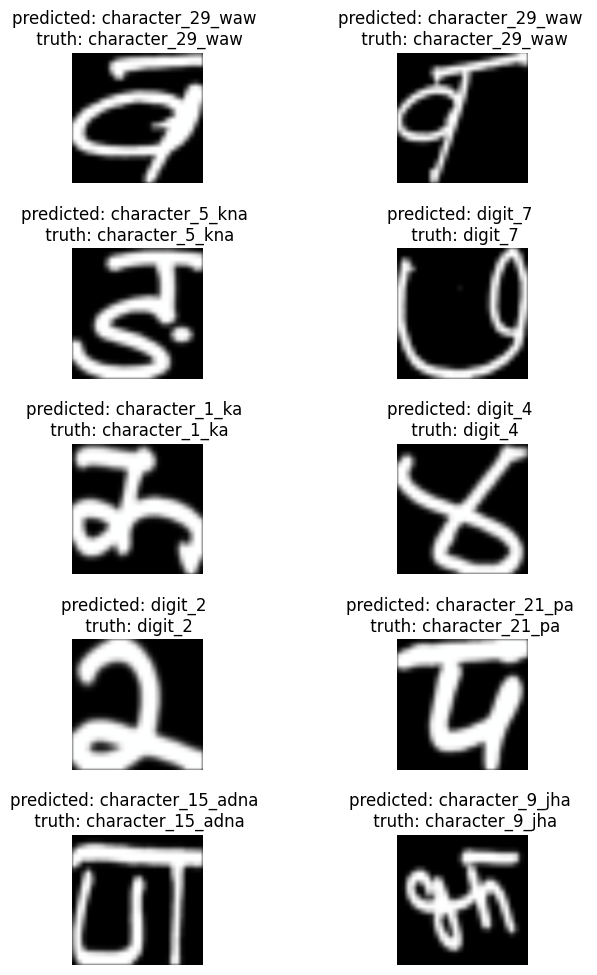

In [17]:
class_names = image_datasets['Train'].classes
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()
   # Adjust the layout parameters for increased spacing
   plt.subplots_adjust(top=2, bottom=0.1, left=0.05, right=0.95, hspace=0.5, wspace=0.3)

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(dataloaders['Test']):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} \n truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img = std * img + mean
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)


visualize_model(model, 10)

plt.show()

# Save the Model

In [18]:
 torch.save(model, '/content/model_state.pth')

In [19]:
print("train_loss_values", train_loss_values)
print("test_loss_values", test_loss_values)

train_loss_values [1.633045885197037, 0.7942896052882494, 0.683049278085494, 0.6285839377827657, 0.5904037513208511]
test_loss_values [0.11748894339454347, 0.06092065114473951, 0.042921163629794465, 0.03587554124818332, 0.03077713066469068]


# Confusion Matrix with CM Visualization

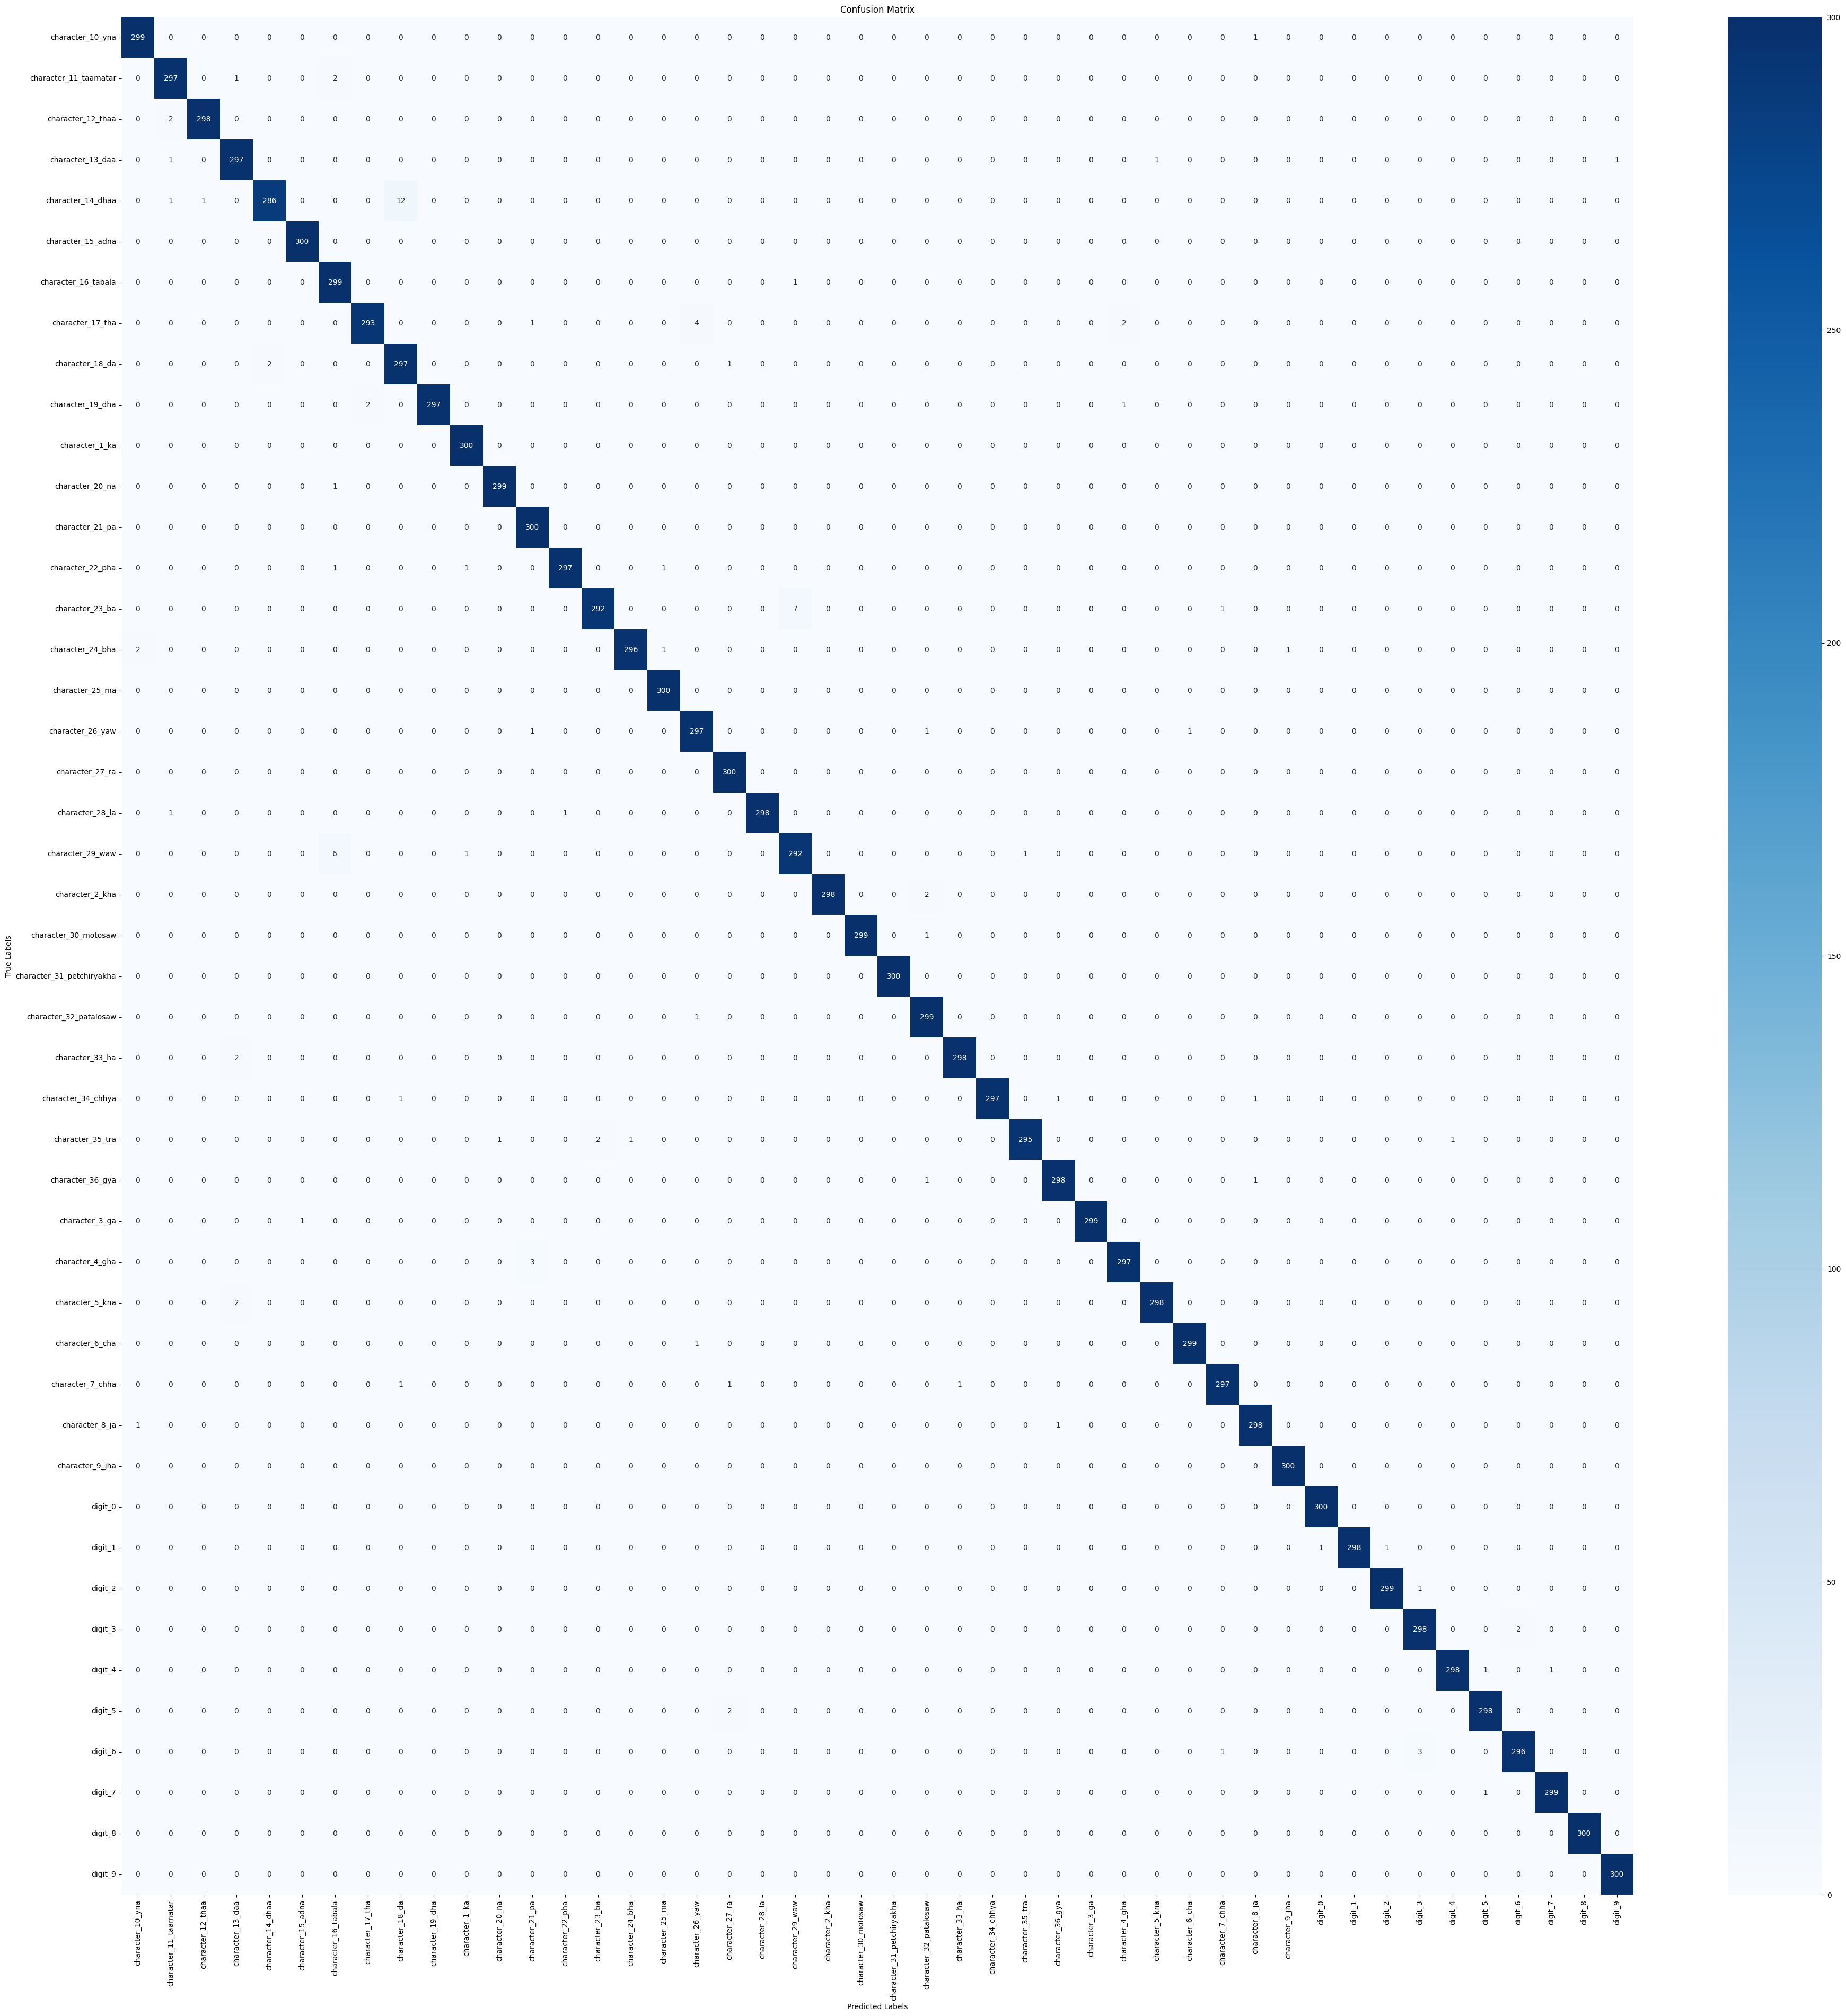

In [20]:
# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Iterate over the test dataset to collect predictions and true labels
with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
classes = image_datasets['Test'].classes
plt.figure(figsize=(len(classes), len(classes)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Identify Misclassifications

In [21]:
# Identify misclassifications
misclassifications = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and conf_matrix[i, j] > 0:
            misclassifications.append((classes[i], classes[j], conf_matrix[i, j]))

# Sort misclassifications by count in descending order
misclassifications.sort(key=lambda x: x[2], reverse=True)

# Print the most confused character pairs
print("Most Confused Character Pairs:")
for pair in misclassifications:
    print(f"{pair[0]} misclassified as {pair[1]}: {pair[2]} times")


Most Confused Character Pairs:
character_14_dhaa misclassified as character_18_da: 12 times
character_23_ba misclassified as character_29_waw: 7 times
character_29_waw misclassified as character_16_tabala: 6 times
character_17_tha misclassified as character_26_yaw: 4 times
character_4_gha misclassified as character_21_pa: 3 times
digit_6 misclassified as digit_3: 3 times
character_11_taamatar misclassified as character_16_tabala: 2 times
character_12_thaa misclassified as character_11_taamatar: 2 times
character_17_tha misclassified as character_4_gha: 2 times
character_18_da misclassified as character_14_dhaa: 2 times
character_19_dha misclassified as character_17_tha: 2 times
character_24_bha misclassified as character_10_yna: 2 times
character_2_kha misclassified as character_32_patalosaw: 2 times
character_33_ha misclassified as character_13_daa: 2 times
character_35_tra misclassified as character_23_ba: 2 times
character_5_kna misclassified as character_13_daa: 2 times
digit_3 mis